### 프로젝트 루브릭
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110,000 이하의 점수를 얻었는가?


## Project

In [149]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
import sklearn
import xgboost as xgb
import lightgbm as lgb

print(xgb.__version__)
print(lgb.__version__)
print(msno.__version__)
print(sklearn.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SEED=42

1.4.2
3.3.0
0.5.0
1.0


### EDA

#### meaninig of columns
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [64]:
data_dir = '~/aiffel/kaggle_kakr_housing/data'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
sub_data_path = join(data_dir, 'sample_submission.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)
print(sub_data_path)

~/aiffel/kaggle_kakr_housing/data/train.csv
~/aiffel/kaggle_kakr_housing/data/test.csv
~/aiffel/kaggle_kakr_housing/data/sample_submission.csv


In [65]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

#### 결측치

<AxesSubplot:>

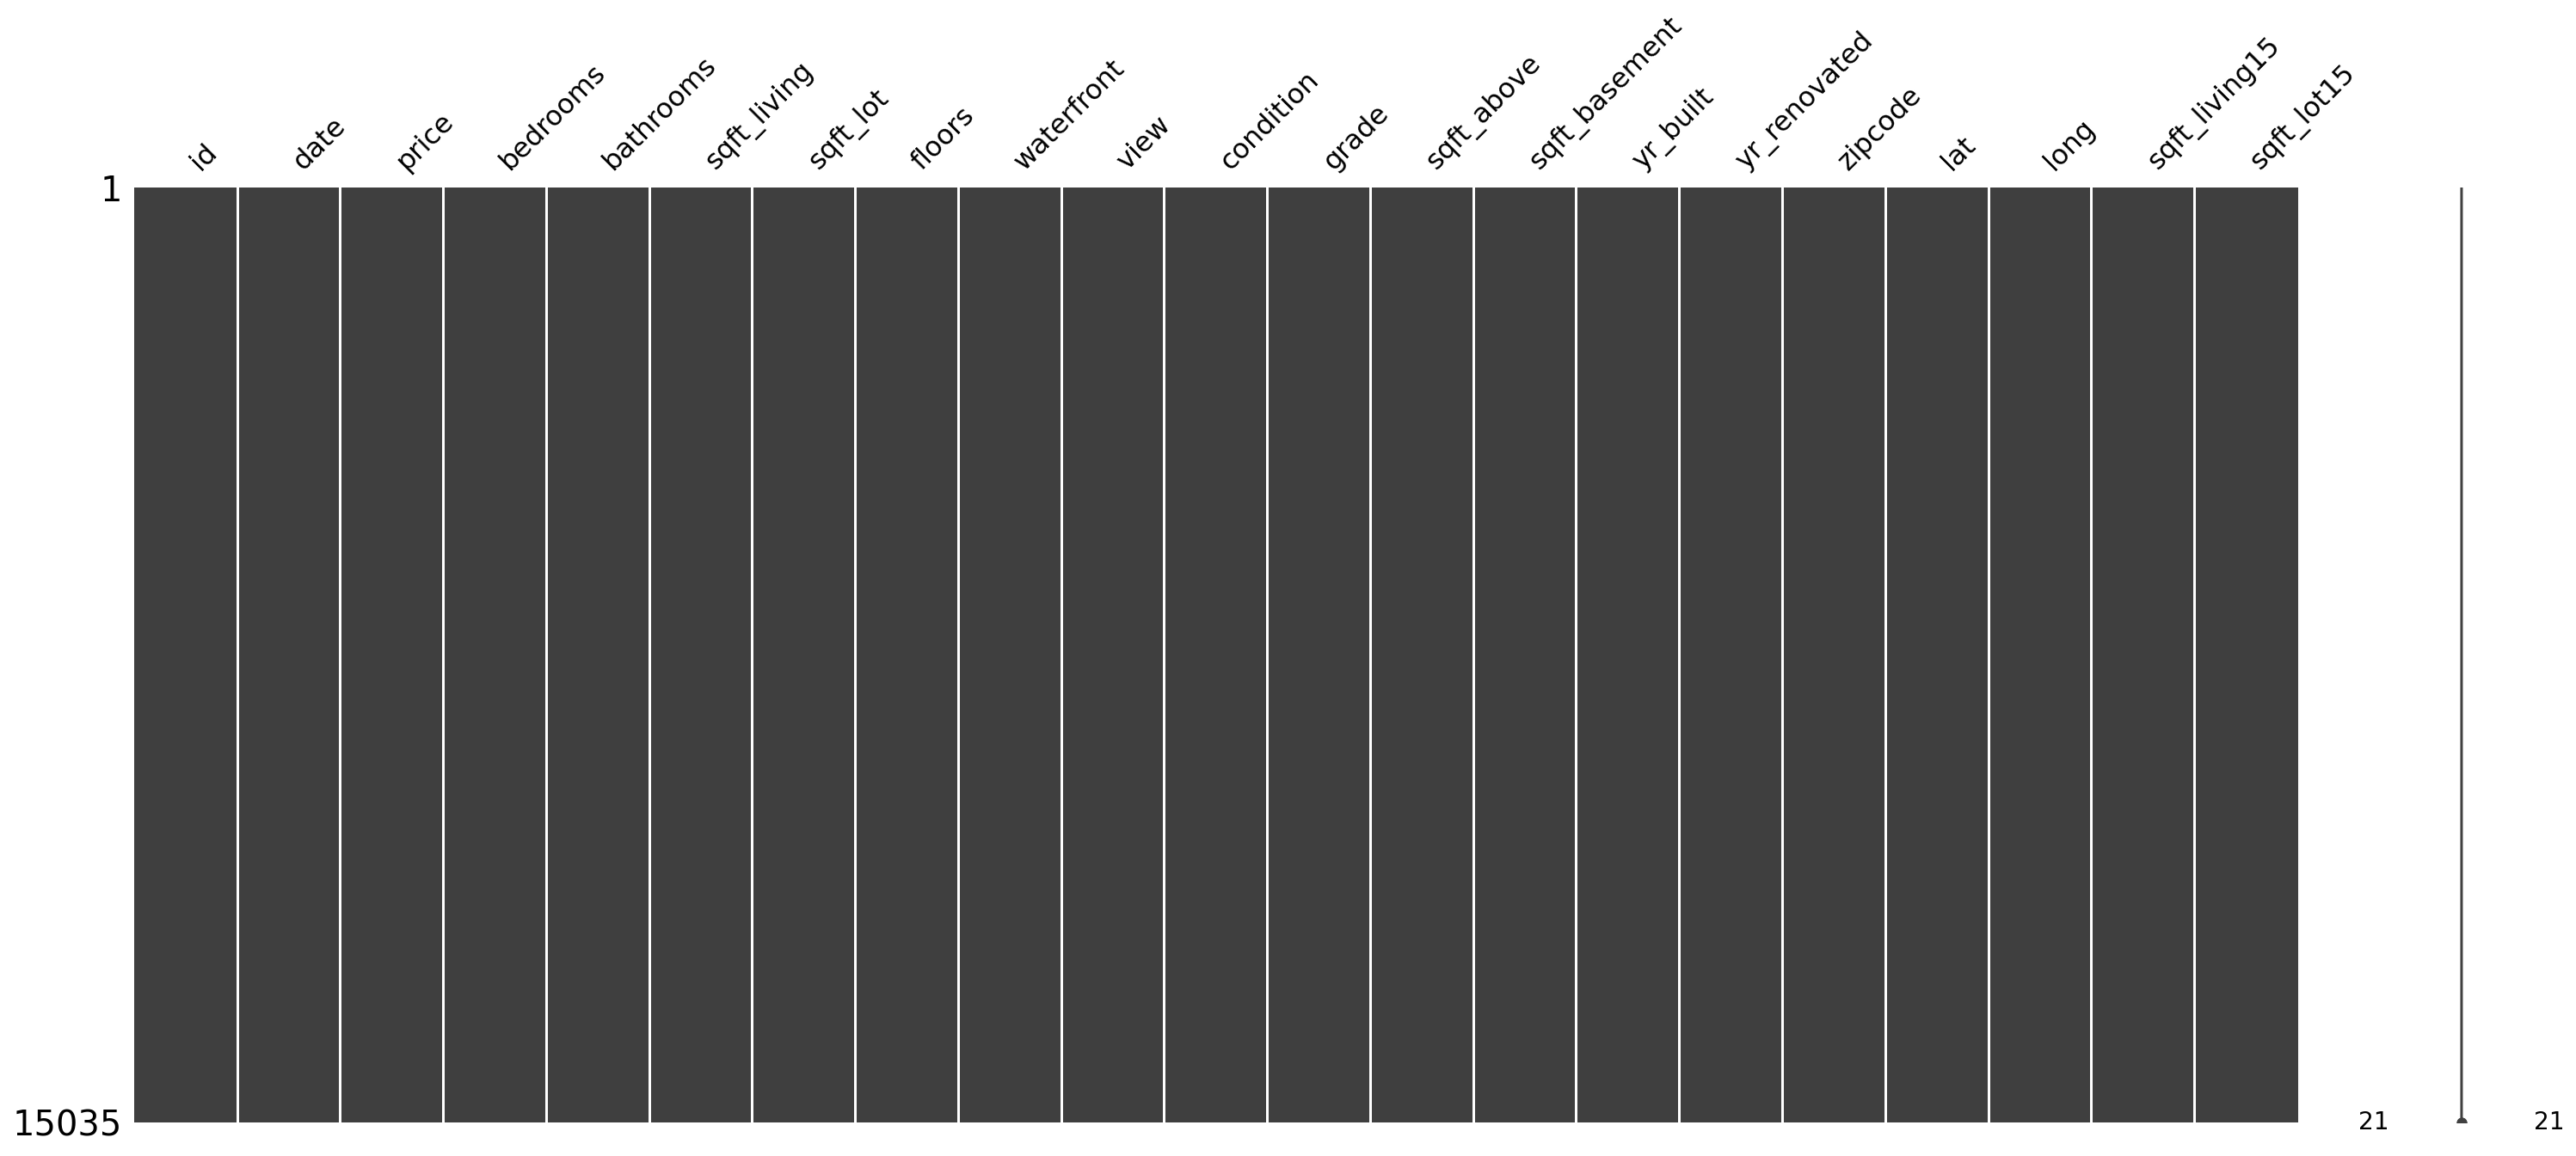

In [8]:
msno.matrix(train)

<AxesSubplot:>

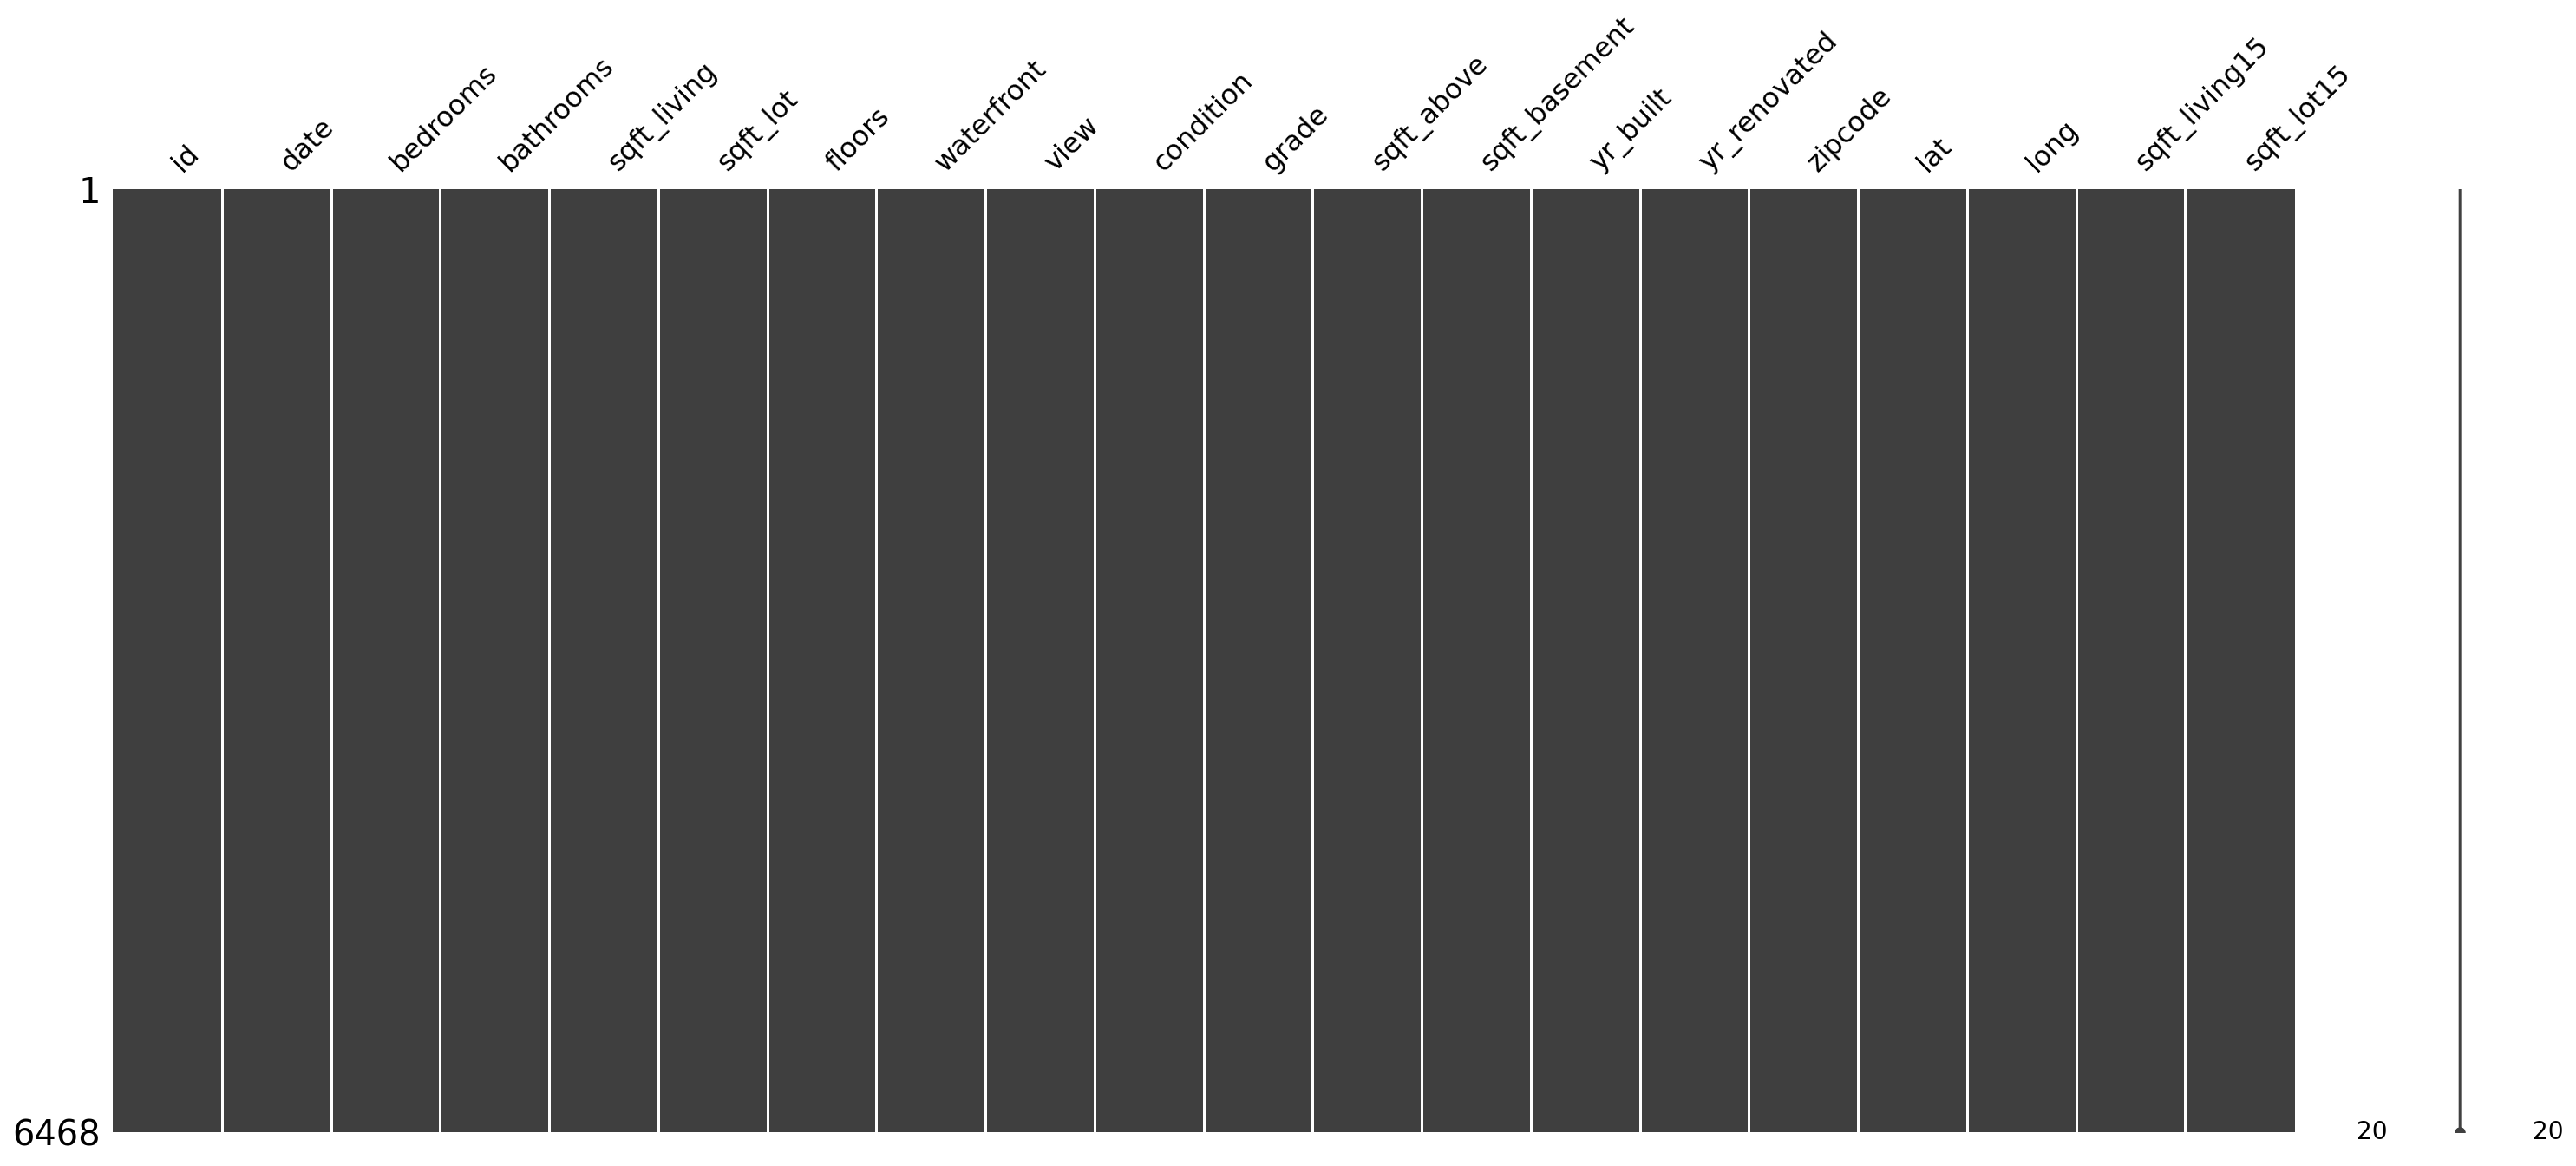

In [12]:
msno.matrix(test)

모든 변수에 결측치가 없는 것으로 보인다.

In [ ]:
def report_missing_no(data)
    for c in data.columns:
        print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
report_missing_no(train)
report_missing_no(test)

#### 이상치

#### 

#### 상관관계 분석

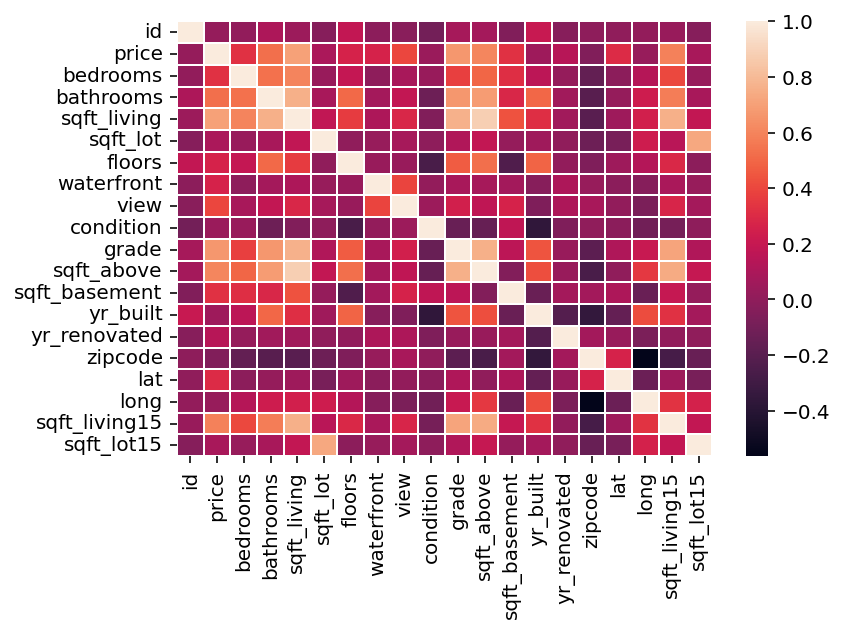

In [16]:
pivot = train.corr()

sns.heatmap(pivot, linewidths=.2,)# annot=True, fmt="f")
plt.show()

In [24]:
train.columns[train.columns.str.startswith( 'sqft')]

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

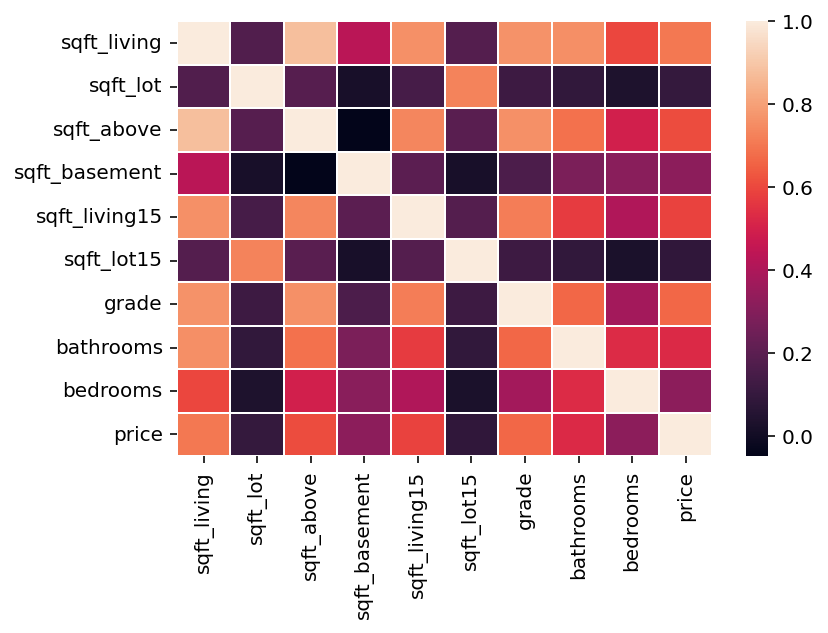

In [32]:
sqrt_columns = list(train.columns[train.columns.str.startswith( 'sqft')])
corr_columns = sqrt_columns + ['grade', 'bathrooms', 'bedrooms', 'price']
pivot = train[corr_columns].corr()

sns.heatmap(pivot, linewidths=.2,)# annot=True, fmt="f")
plt.show()

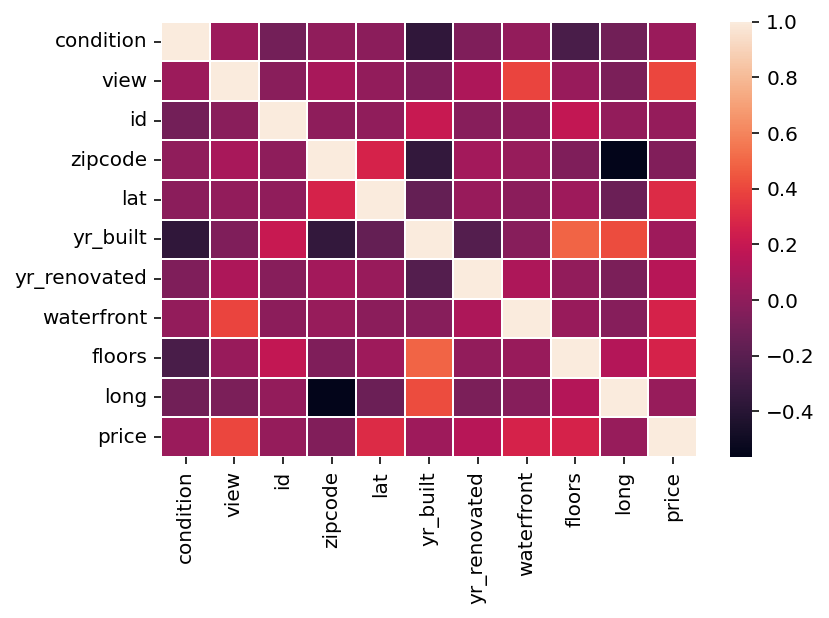

In [33]:
anti_corr_columns = list(set(train.columns) - set(corr_columns))

pivot = train[anti_corr_columns + ['price']].corr()

sns.heatmap(pivot, linewidths=.2,)# annot=True, fmt="f")
plt.show()

### Experiments

시도해볼 수 있는 방법
여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

물론 이 외에도 좋은 아이디어가 있다면 당연히 시도해보는 것도 좋습니다. 자유롭게 여러 가지 방법을 활용해서 점수를 끌어올려 보세요!
참고로, 진행하면서 도움이 될 수 있는 가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널입니다.

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks
아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!


### Pre-processing

In [66]:
# transform skewed features and price

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

def log1p_transform_columns(data, skew_columns):
    data = data.copy()
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

train = log1p_transform_columns(train, skew_columns=skew_columns+['price'])
test = log1p_transform_columns(test, skew_columns=skew_columns)

def convert_date(df):
    df = df.copy()
    df['year'] = df['date'].apply(lambda x: int(x[:4]))
    df['month'] = df['date'].apply(lambda x: int(x[4:6]))
    df['day'] = df['date'].apply(lambda x: int(x[6:8]))
    df['date'] = df['date'].apply(lambda x: int(x[:8]))
    return df

train = convert_date(train)
test = convert_date(test)

# del unused meaningless column id
del train['id'], test['id']


# cut price column into a target 'y'
# del from train
y = train['price']
del train['price']

In [67]:
from sklearn.metrics import mean_squared_error
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [93]:
from sklearn.model_selection import train_test_split
def get_scores(models, X, y, retrain=False):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        if retrain:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)
        else:
            X_test, y_test = X, y

        # 모델 학습
        if retrain: model.fit(X_train, y_train)
        
        # 예측
        predictions = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(predictions, y_test)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return df

In [ ]:
from sklearn.model_selection import GridSearchCV
def my_GridSearch(model, train, y, param_grid, 
                  verbose=2, n_jobs=5, cv=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=cv, verbose=1, n_jobs=5)

    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    scores = grid_model.cv_results_['mean_test_score']

    for param, score in zip(params, scores):
        param.update({'score': score})


    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * results['score'])

    return (grid_model, 
            results.sort_values('RMSLE', ascending=True),
           )


In [ ]:
def AveragingBlending(models, X_test, retrain=False, X_train=None, y_train=None):
    if retrain:
        assert X_train is not None and y_train is not None
        for m in models : 
            m['model'].fit(X_train, y_train)
    
    predictions = np.column_stack([
        m['model'].predict(X_test) for m in models
    ])
    return np.mean(predictions, axis=1)

In [95]:
models = [
    sklearn.ensemble.RandomForestRegressor(), 
    xgb.XGBRegressor(), 
    lgb.LGBMRegressor()
]
socores_dict = get_scores(models, train, y, retrain=True)
socores_dict

{'RandomForestRegressor': 140230.90926598632,
 'XGBRegressor': 122807.72369441569,
 'LGBMRegressor': 122307.96263008595}

In [100]:
cum_results = pd.read_csv('hyparam_lgb.csv') # None

In [170]:
model = lgb.LGBMRegressor()
param_grid_lgb = {
    'n_estimators': [500, 600,], #500, 600, 700, ],
    'max_depth': [15,],
    'learning_rate': [ 0.05,], #0.005, 0.001, 5e-4], 
    }

In [171]:
grid_model, results = my_GridSearch(model, train, y, 
                                    n_jobs=5,
                                    param_grid=param_grid_lgb)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [160]:
cum_results = pd.concat([cum_results, results], axis=0).drop_duplicates() if cum_results is not None else results

In [161]:
cum_results.sort_values('RMSLE', ascending = True)

,max_depth,n_estimators,score,RMSLE,learning_rate
2,15,600,-0.026058,0.161424,0.0500
1,15,500,-0.026060,0.161430,0.0500
5,20,600,-0.026060,0.161432,0.0500
5,20,700,-0.026061,0.161435,0.0500
4,20,500,-0.026073,0.161473,0.0500
6,20,800,-0.026077,0.161484,0.0500
7,20,900,-0.026094,0.161536,0.0500
1,15,700,-0.026104,0.161568,0.0500
2,15,300,-0.026160,0.161739,0.1000
1,15,400,-0.026160,0.161741,0.0500


In [162]:
cum_results.sort_values('RMSLE', ascending = True).to_csv('hyparam_lgb.csv', index=False)

In [163]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(grid_model.best_estimator_, X=train, y=y, 
                scoring = 'neg_mean_squared_error',
                cv=5, n_jobs=5)
cv_rmsle = np.sqrt(-1 * cv_scores)
cv_rmsle            

array([0.15991883, 0.16516667, 0.16649175, 0.16291786, 0.15222654])

#### (deprecated: Too much time cost) 

In [157]:
import joblib
joblib.cpu_count()

2

In [168]:
model = xgb.XGBRegressor(random_state = random_state)
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV

estimators=[
        ('rf', RandomForestRegressor()), 
#         ('xgb', xgb.XGBRegressor()),   # discarded too much time 
        ('lgb', lgb.LGBMRegressor()),]

# model = StackingRegressor(
#     estimators=estimators, 
# #     final_estimator=RidgeCV(),            # default is RidgeCV
#     cv=5, n_jobs=5, 
#     passthrough=True, verbose=0)


model = VotingRegressor(
    estimators=estimators,
    verbose=True, n_jobs=5, 
)
param_grid = {
#     'xgb__n_estimators': [50, 100],
#     'xgb__max_depth': [1, 10],
}

param_grid_rf = {
    'n_estimators': [500, 600,],
    'max_depth': [15,],
}

param_grid.update({'rf__'+key: val for key, val in param_grid_rf.items() })
param_grid.update({'lgb__'+key: val for key, val in param_grid_lgb.items() })

grid_model, results = my_GridSearch(model, train, y, param_grid=param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [91]:
get_scores(models = [grid_model.best_estimator_], X=train, y=y, retrain=True)

{'XGBRegressor': 130348.09101143607}

In [77]:
results

,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030548,0.174780
3,10,100,-0.030757,0.175377
1,1,100,-0.043049,0.207483
0,1,50,-0.048757,0.220810


In [174]:
grid_model.best_estimator_

LGBMRegressor(learning_rate=0.05, max_depth=15, n_estimators=600)

In [175]:

def save_submission(model, train, y, test, model_name=None, rmsle=None, 
                    retrain=False):
    # train model again with train dataset if retrain is True
    if retrain: model.fit(train, y)
    
    # get prediction from retrained model
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction

    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

In [178]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(grid_model.best_estimator_, X=train, y=y, 
                scoring = 'neg_mean_squared_error',
                cv=5, n_jobs=5)
cv_rmsle = np.sqrt(-1 * cv_scores)
rmsle = cv_rmsle.mean()

In [176]:
save_submission(grid_model.best_estimator_, train, y, test,
                model_name='voting_xgb_rf_lgb',
                rmsle=rmsle)

### 캐글 Submission 스코어

image:![](https://i.imgur.com/zx8XfLs.png)


시도해볼 수 있는 방법
여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기